# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [26]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [28]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [36]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [37]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [68]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.03333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [69]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch 20
Loss: 2.521494, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.435535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.550417, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.423037, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.456231, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.424469, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.481331, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.543597, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.444922, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.435973, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.431616, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.507563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.475200, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.404680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.599031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.399215, 

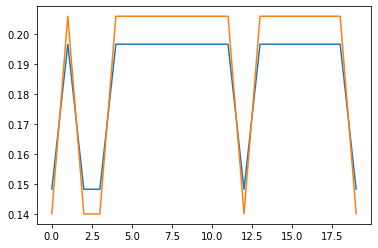

In [70]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [71]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch 20
Loss: 3.201538, Train accuracy: 0.286333, val accuracy: 0.305000
Loss: 6.466095, Train accuracy: 0.491667, val accuracy: 0.486000
Loss: 8.291924, Train accuracy: 0.539667, val accuracy: 0.550000
Loss: 8.479124, Train accuracy: 0.540556, val accuracy: 0.542000
Loss: 8.795352, Train accuracy: 0.513556, val accuracy: 0.512000
Loss: 8.881693, Train accuracy: 0.536667, val accuracy: 0.551000
Loss: 9.523619, Train accuracy: 0.585667, val accuracy: 0.592000
Loss: 10.144016, Train accuracy: 0.522556, val accuracy: 0.516000
Loss: 9.275252, Train accuracy: 0.588000, val accuracy: 0.570000
Loss: 9.949891, Train accuracy: 0.644667, val accuracy: 0.616000
Loss: 10.044272, Train accuracy: 0.546889, val accuracy: 0.538000
Loss: 9.553313, Train accuracy: 0.619444, val accuracy: 0.617000
Loss: 9.386824, Train accuracy: 0.616222, val accuracy: 0.622000
Loss: 9.679045, Train accuracy: 0.551444, val accuracy: 0.542000
Loss: 9.324923, Train accuracy: 0.616889, val accuracy: 0.598000
Loss: 10.12785

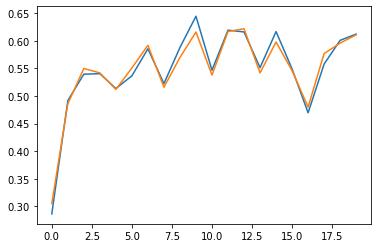

In [72]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [73]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch 20
Loss: 2.306898, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270254, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.440128, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.146598, Train accuracy: 0.203000, val accuracy: 0.212000
Loss: 2.447987, Train accuracy: 0.250111, val accuracy: 0.252000
Loss: 2.542941, Train accuracy: 0.273778, val accuracy: 0.276000
Loss: 2.712985, Train accuracy: 0.288111, val accuracy: 0.292000
Loss: 3.003564, Train accuracy: 0.339111, val accuracy: 0.348000
Loss: 3.330883, Train accuracy: 0.413778, val accuracy: 0.405000
Loss: 3.659546, Train accuracy: 0.440111, val accuracy: 0.422000
Loss: 3.935756, Train accuracy: 0.468444, val accuracy: 0.458000
Loss: 4.544683, Train accuracy: 0.485333, val accuracy: 0.463000
Loss: 4.996675, Train accuracy: 0.526667, val accuracy: 0.520000
Loss: 4.801896, Train accuracy: 0.542333, val accuracy: 0.535000
Loss: 5.549211, 

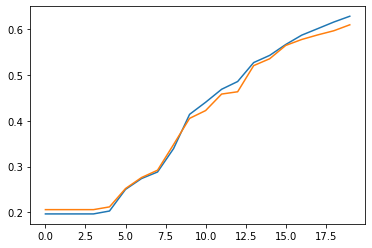

In [74]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [81]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch 150
Loss: 2.339393, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.335139, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.310308, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.308598, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301213, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.299517, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.305779, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.264685, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.117731, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.281214, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.276083, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.202493, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.704300, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.624032, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.072250, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.633641,

Loss: 1.261945, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.330619, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.225875, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.282641, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.346030, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.157242, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.485450, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.277119, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.249835, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.191142, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.263796, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.318123, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.393242, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.355884, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.497341, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.374477, Train acc

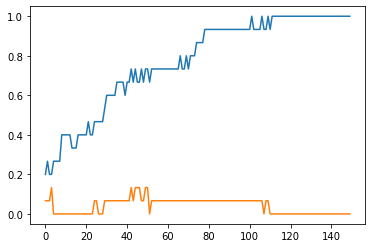

In [84]:
plt.plot(train_history)
plt.plot(val_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [79]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Epoch 20
Loss: 2.327081, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.327607, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.317494, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.279503, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.310900, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.269795, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.300845, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.268417, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.255819, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.347785, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.353958, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.942773, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.231477, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.127795, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.705590, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.989122, 

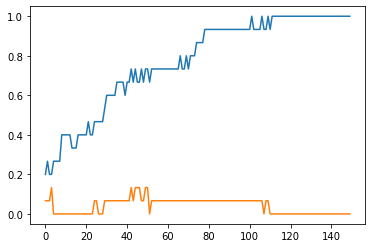

In [85]:
plt.plot(train_history)
plt.plot(val_history)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [109]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1]
reg_strengthes = [1e-4]
learning_rate_decays = [0.999]
hidden_layer_size = 128
num_epochs = 20
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

for learning_rate in learning_rates:
    for reg_strength in reg_strengthes:
        for learning_rate_decay in learning_rate_decays:
            model = TwoLayerNet(n_input = train_X.shape[1]
                                , n_output = 10
                                , hidden_layer_size = hidden_layer_size
                                , reg = reg_strength
                               )
            dataset = Dataset(train_X, train_y, val_X, val_y)
            trainer = Trainer(model
                              , dataset
                              , SGD()
                              , learning_rate=learning_rate
                              , num_epochs=num_epochs
                              , batch_size=batch_size
                              , learning_rate_decay=learning_rate_decay
                             )
            cur_loss_history, cur_train_history, cur_val_history = trainer.fit()
            if best_val_accuracy is None or np.max(cur_val_history) > best_val_accuracy:
                best_val_accuracy = np.max(cur_val_history)
                best_classifier = model
                loss_history, train_history, val_history = cur_loss_history, cur_train_history, cur_val_history

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 20
Loss: 2.182119, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209717, Train accuracy: 0.216556, val accuracy: 0.223000
Loss: 1.966130, Train accuracy: 0.274556, val accuracy: 0.275000
Loss: 1.802143, Train accuracy: 0.355000, val accuracy: 0.350000
Loss: 1.579845, Train accuracy: 0.433444, val accuracy: 0.430000
Loss: 1.444046, Train accuracy: 0.487778, val accuracy: 0.468000
Loss: 1.244089, Train accuracy: 0.548222, val accuracy: 0.542000
Loss: 1.333375, Train accuracy: 0.593111, val accuracy: 0.594000
Loss: 1.079482, Train accuracy: 0.635889, val accuracy: 0.636000
Loss: 1.006924, Train accuracy: 0.663111, val accuracy: 0.643000
Loss: 1.240364, Train accuracy: 0.670000, val accuracy: 0.659000
Loss: 1.064442, Train accuracy: 0.686333, val accuracy: 0.671000
Loss: 1.028612, Train accuracy: 0.652556, val accuracy: 0.650000
Loss: 0.942077, Train accuracy: 0.694111, val accuracy: 0.654000
Loss: 0.916937, 

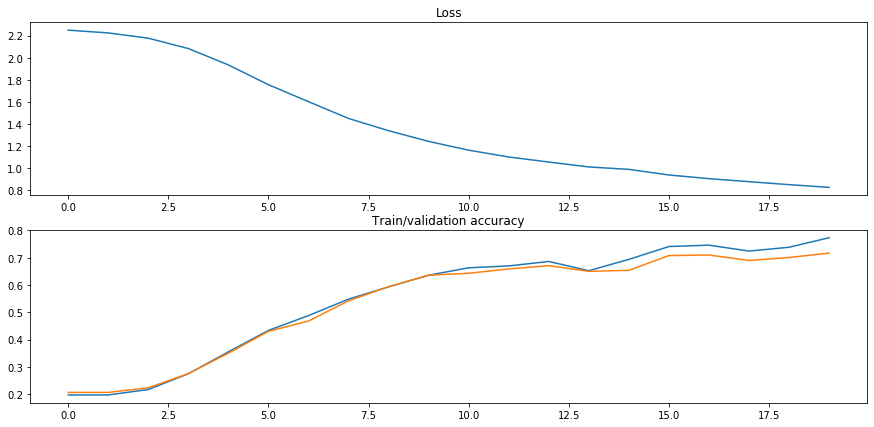

In [110]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [111]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.676000
